In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler


In [2]:
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')


In [3]:
df = pd.read_csv('true_car_listings.csv')
pd.set_option('display.max.columns', None)
df.head()
df.isna().sum()


Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [4]:
df.describe()

,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


In [5]:
len(df) - len(df.drop_duplicates())

30

In [6]:
df = df.drop_duplicates()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852092 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852092 non-null  int64 
 1   Year     852092 non-null  int64 
 2   Mileage  852092 non-null  int64 
 3   City     852092 non-null  object
 4   State    852092 non-null  object
 5   Vin      852092 non-null  object
 6   Make     852092 non-null  object
 7   Model    852092 non-null  object
dtypes: int64(3), object(5)
memory usage: 58.5+ MB


In [8]:
def get_info(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))).sum()
    d = {'Mean' : [round(data[feature].mean(),2)] , 'Median' : [round(data[feature].median(),2)], 'Outlier' : [total_outlier_num]}
    df_info = pd.DataFrame(data = d, index = [f'{feature}'])
    return df_info
    
get_info(df, "Price")

,Mean,Median,Outlier
Price,21464.32,18500.0,28025


In [9]:
df[df["Mileage"]>500000]

,Price,Year,Mileage,City,State,Vin,Make,Model
69149,35130,2016,999999,Missouri Valley,IA,1G4GA5GR7GF178536,Buick,LaCrosseFWD
84101,36995,2012,535778,Liberty Lake,WA,1GYS4CEFXCR193960,Cadillac,EscaladeAWD
84167,14995,2011,950133,Nashua,NH,3GYFNDEY3BS642767,Cadillac,SRXAWD
186303,3995,2005,610451,Bethlehem,PA,1GCGG29V951239116,Chevrolet,Express
186424,19988,2009,777077,Jacksonville,FL,3GNCA13B19S617966,Chevrolet,HHRFWD
186438,40578,2015,714040,Midland,TX,1GNSCBKCXFR155962,Chevrolet,Tahoe2WD
186440,17477,2006,999999,Missouri Valley,IA,1GCHK23U76F149017,Chevrolet,Silverado
186444,21889,2014,999999,Missouri Valley,IA,1GNKVHKD4EJ186711,Chevrolet,Traverse2LT
186445,26265,2013,999999,Missouri Valley,IA,3GCPKSE76DG229343,Chevrolet,Silverado
186446,27675,2013,999999,Missouri Valley,IA,3GCPKSE70DG207810,Chevrolet,Silverado


In [10]:
Q1 = df["Mileage"].quantile(0.05)
Q3 = df["Mileage"].quantile(0.95)
IQR = Q3 - Q1
total_outlier_num = ((df["Mileage"] < (Q1 - 1.5 * IQR)) | (df["Mileage"] > (Q3 + 1.5 * IQR))).sum()
df_final = df[~((df["Mileage"] < (Q1 - 1.5 * IQR)) | (df["Mileage"] > (Q3 + 1.5 * IQR)))] ## DataFrame à mettre de côté sans les outlier (pour test)
df_outlier = df[((df["Mileage"] < (Q1 - 1.5 * IQR)) | (df["Mileage"] > (Q3 + 1.5 * IQR)))] 
df_outlier = df_outlier.reset_index(drop = True).sort_values(by="Mileage")
df_outlier["Mileage"].value_counts()  

999999     18
777777      2
368141      2
326049      1
412317      1
           ..
351024      1
351057      1
351160      1
351769      1
2856196     1
Name: Mileage, Length: 191, dtype: int64

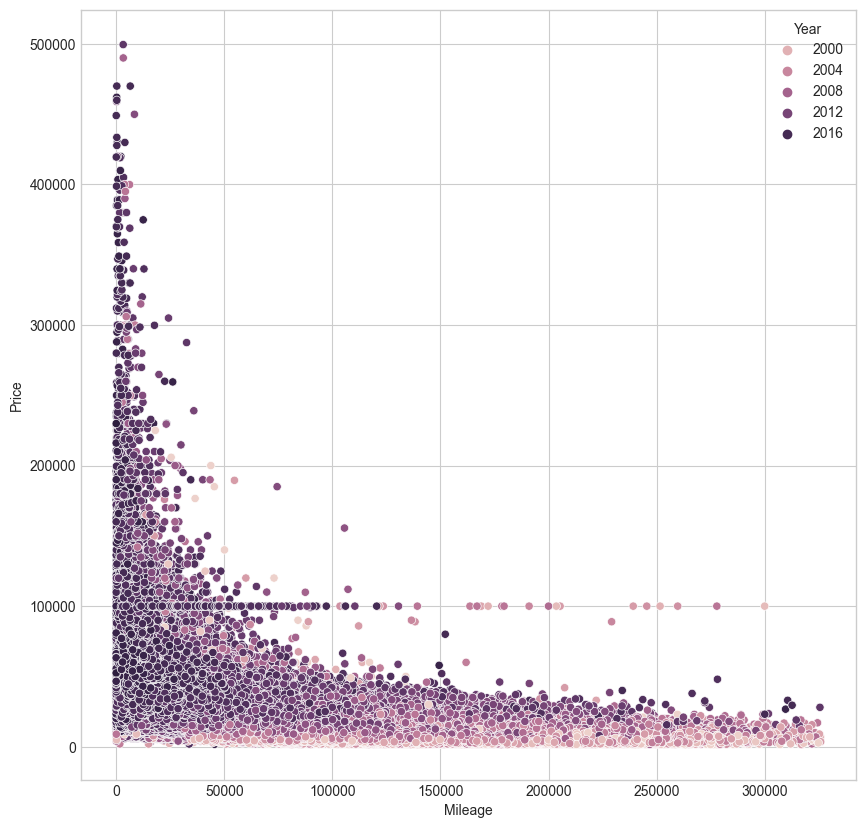

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = df_final, x="Mileage", y="Price", hue = "Year");

In [12]:
corr = df.corr()

In [13]:
#sns.heatmap(corr, annot = True, linewidths=0.5);

In [14]:
X = df[["Year", "Mileage", "Make"]]
y = df[["Price"]]
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
num_selector = make_column_selector(dtype_exclude=["object"])
cat_selector = make_column_selector(dtype_include=["object"])

cat_processor = OneHotEncoder()
num_processor = StandardScaler()

In [16]:
df["Model"].value_counts().to_list()

[24929,
 17321,
 14502,
 14177,
 11288,
 11273,
 11208,
 11131,
 7975,
 7953,
 7340,
 6708,
 6386,
 6223,
 5449,
 5348,
 5327,
 5144,
 4825,
 4637,
 4530,
 4515,
 4426,
 4243,
 4172,
 4096,
 4027,
 3990,
 3879,
 3708,
 3648,
 3622,
 3577,
 3510,
 3480,
 3380,
 3357,
 3339,
 3325,
 3316,
 3239,
 3204,
 3125,
 3104,
 2998,
 2968,
 2931,
 2857,
 2754,
 2747,
 2729,
 2703,
 2697,
 2694,
 2686,
 2675,
 2653,
 2615,
 2601,
 2521,
 2506,
 2505,
 2501,
 2495,
 2459,
 2443,
 2418,
 2416,
 2404,
 2361,
 2358,
 2354,
 2337,
 2305,
 2305,
 2266,
 2216,
 2197,
 2195,
 2174,
 2131,
 2114,
 2109,
 2095,
 2059,
 2054,
 2028,
 2018,
 2009,
 1972,
 1896,
 1892,
 1889,
 1876,
 1822,
 1820,
 1787,
 1780,
 1761,
 1758,
 1749,
 1741,
 1732,
 1714,
 1701,
 1665,
 1658,
 1629,
 1627,
 1627,
 1627,
 1626,
 1615,
 1592,
 1585,
 1585,
 1573,
 1568,
 1542,
 1530,
 1527,
 1521,
 1518,
 1497,
 1495,
 1490,
 1489,
 1488,
 1460,
 1454,
 1450,
 1447,
 1439,
 1437,
 1435,
 1416,
 1401,
 1399,
 1397,
 1394,
 1394,
 1388

In [19]:
df[df["Model"] > 1000].sum()

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
df